In [26]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.saving import register_keras_serializable
import matplotlib.pyplot as plt
import soundfile as sf

In [27]:
def extract_features(audio_file, sr=16000):
    # Load audio
    input_audio, sr = librosa.load(audio_file, sr=sr, mono=False)

    # Parameters for feature extraction
    win_len = int(0.02 * sr)  # 20ms window
    step_len = int(0.01 * sr)  # 10ms step
    fixed_sample_len = int(0.64 * sr)  # Fixed length for padding
    fixed_pad_len = int(fixed_sample_len / step_len)

    # Mel-spectrogram feature extraction
    spectra_fea = []
    linear_spectra = []
    for ch_cnt in range(4):
        spec_ch = librosa.feature.melspectrogram(
            y=input_audio[ch_cnt, :],
            sr=sr,
            n_fft=2048,
            hop_length=step_len,
            n_mels=64,
            win_length=win_len,
            window='hann',
            fmin=0,
            fmax=8000
        )
        spec_ch = np.log(spec_ch)

        # z-score normalization
        std_val = spec_ch.std()
        mean_val = spec_ch.mean()
        spec_ch = (spec_ch - mean_val) / std_val + 1e-8

        # padding to fixed shape
        f_len = spec_ch.shape[0]
        spec_ch_padded = np.zeros((f_len, fixed_pad_len), dtype='float32')
        tmp = spec_ch[:, :fixed_pad_len]
        spec_ch_padded[:, 0:tmp.shape[1]] = tmp
        spectra_fea.append(spec_ch_padded)

        # Linear spectrogram for GCC-PHAT
        linear_spectra_ch = librosa.core.stft(
            np.asfortranarray(input_audio[ch_cnt, :]),
            n_fft=2048,
            hop_length=step_len,
            win_length=win_len,
            window='hann'
        )
        linear_spectra.append(linear_spectra_ch)

    linear_spectra = np.array(linear_spectra).T

    # GCC-PHAT feature extraction
    gcc_channels = 6
    gcc_fea = np.zeros((fixed_pad_len, 64, gcc_channels))
    cnt = 0
    for m in range(linear_spectra.shape[-1]):
        for n in range(m + 1, linear_spectra.shape[-1]):
            R = np.conj(linear_spectra[:, :, m]) * linear_spectra[:, :, n]
            cc = np.fft.irfft(np.exp(1.j * np.angle(R)))
            cc = np.concatenate((cc[:, -64 // 2:], cc[:, :64 // 2]), axis=-1)

            # z-score normalization
            std_val = cc.std()
            mean_val = cc.mean()
            cc = (cc - mean_val) / std_val + 1e-8

            # padding
            tmp = cc[:fixed_pad_len, :]
            gcc_fea[0:tmp.shape[0], :, cnt] = tmp
            cnt += 1

    # Reshape features to match model input shape
    gcc_fea = gcc_fea.transpose((1, 0, 2))  # (freq_dim x time_dim x channel_num)
    spectra_fea = np.array(spectra_fea).transpose((1, 2, 0))  # (freq_dim x time_dim x channel_num)

    # Reshape for model input
    gcc_fea = gcc_fea.reshape(1, gcc_fea.shape[0], -1)  # Shape: (1, 64, 64*6)
    spectra_fea = spectra_fea.reshape(1, spectra_fea.shape[0], -1)  # Shape: (1, 64, 64*4)

    print("Features Extracted")
    return gcc_fea, spectra_fea



In [28]:
def detect_footsteps(audio_file, sr=16000):
    """
    Detect individual footsteps in the audio file and return their start times
    """
    # Load audio (use first channel for detection)
    audio, sr = librosa.load(audio_file, sr=sr, mono=False)
    audio_mono = audio[0]  # Use first channel for detection

    # Compute onset strength
    onset_env = librosa.onset.onset_strength(y=audio_mono, sr=sr)

    # Detect onset peaks (footsteps)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env,
                                            sr=sr,
                                            wait=10,  # Minimum number of frames between onset detections
                                            pre_avg=10,  # Number of frames for onset envelope normalization
                                            post_avg=10,
                                            pre_max=10,
                                            post_max=10)

    # Convert frames to time
    onset_times = librosa.frames_to_time(onset_frames)

    return onset_times, audio


In [29]:
def segment_audio(audio, onset_times, sr=16000, segment_duration=0.64):
    """
    Segment audio into individual footstep segments
    """
    segments = []
    segment_samples = int(segment_duration * sr)

    for onset_time in onset_times:
        start_sample = int(onset_time * sr)
        end_sample = start_sample + segment_samples

        # Create segment for all channels
        segment = np.zeros((audio.shape[0], segment_samples))

        # Handle edge case where segment might go beyond audio length
        if end_sample > audio.shape[1]:
            actual_samples = audio.shape[1] - start_sample
            segment[:, :actual_samples] = audio[:, start_sample:audio.shape[1]]
        else:
            segment = audio[:, start_sample:end_sample]

        segments.append(segment)

    return segments

In [30]:
def predict_locations(model_path, audio_file):
    """
    Predict locations for all footsteps in the audio file
    """
    # Detect footsteps
    onset_times, audio = detect_footsteps(audio_file)

    # Segment audio into individual footsteps
    segments = segment_audio(audio, onset_times)

    # Load model
    custom_objects = {'mse': mse}
    model = load_model(model_path, custom_objects=custom_objects)

    # Predict for each segment
    predictions = []

    for i, segment in enumerate(segments):
        # Save temporary segment
        temp_file = f'temp_segment_{i}.wav'
        sf.write(temp_file, segment.T, 16000)

        # Extract features
        gcc_features, spec_features = extract_features(temp_file)

        # Predict
        x_pred, y_pred, subject_pred = model.predict([gcc_features, spec_features])

        # Store predictions
        predictions.append({
            'time': onset_times[i],
            'x': float(x_pred[0][0]),
            'y': float(y_pred[0][0]),
            'subject': np.argmax(subject_pred[0])
        })

        # Clean up temporary file
        os.remove(temp_file)

    return predictions

In [31]:
def plot_footstep_locations(predictions):
    """
    Plot the predicted footstep locations
    """
    plt.figure(figsize=(10, 10))

    # Extract x and y coordinates
    x_coords = [p['x'] for p in predictions]
    y_coords = [p['y'] for p in predictions]
    times = [p['time'] for p in predictions]

    # Create scatter plot with colormap based on time
    scatter = plt.scatter(x_coords, y_coords, c=times, cmap='viridis',
                         s=100, alpha=0.6)

    # Add colorbar to show time progression
    plt.colorbar(scatter, label='Time (seconds)')

    # Add arrows to show movement sequence
    for i in range(len(x_coords)-1):
        plt.arrow(x_coords[i], y_coords[i],
                 x_coords[i+1]-x_coords[i], y_coords[i+1]-y_coords[i],
                 color='gray', alpha=0.3, head_width=0.05)

    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.title('Footstep Locations Over Time')
    plt.grid(True)
    plt.axis('equal')
    return plt

In [32]:
@register_keras_serializable()
def mse(y_true, y_pred):
    return MeanSquaredError()(y_true, y_pred)


Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Features Extracted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Features Extracted
1/1 ━━━━━━━

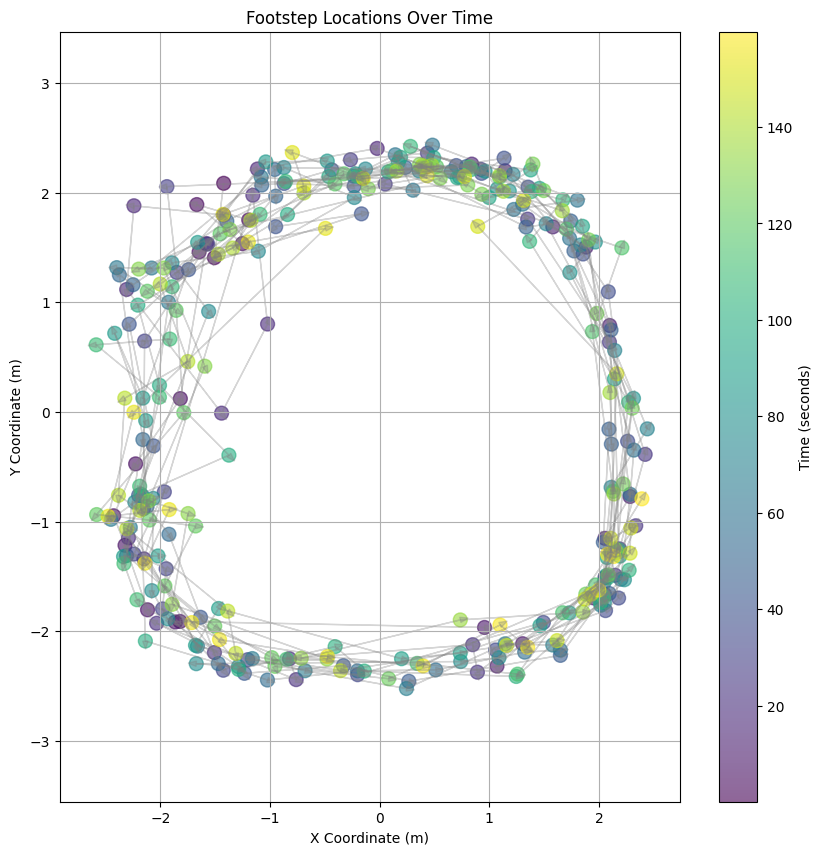

In [33]:
model_path = "/content/best_model.h5"  # Update this path to your model location
audio_file = "/content/s03_1_footstep_audio.wav"  # Update this path to your audio file location

try:
    predictions = predict_locations(model_path, audio_file)

    # Print predictions
    for i, pred in enumerate(predictions):
        print(f"Footstep {i+1} at {pred['time']:.2f}s: x={pred['x']:.2f}, y={pred['y']:.2f}")

    # Plot results
    plt = plot_footstep_locations(predictions)
    plt.show()

except Exception as e:
    print(f"Error during prediction: {str(e)}")